In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [4]:

# Load dataset
df = pd.read_csv(r"/mnt/c/Users/ASUS/Downloads/Amazon_reviews_2023.csv")
df.dropna(subset=['user_id', 'asin', 'rating', 'text'], inplace=True)

# Encode user & items
df['user_id'] = df['user_id'].astype('category').cat.codes
df['asin'] = df['asin'].astype('category').cat.codes

# Binary ratings
df['rating'] = (df['rating'] >= 3).astype(float)
num_users = df['user_id'].nunique()
num_items = df['asin'].nunique()

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Ensure CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset class
class NCFDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user_id'].values, dtype=torch.long)
        self.items = torch.tensor(df['asin'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

# Create data loader
train_loader = DataLoader(NCFDataset(df), batch_size=256, shuffle=True)

# Model class
class NCF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=32):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.fc = nn.Sequential(
            nn.Linear(emb_size * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, user, item):
        user_embedded = self.user_emb(user)
        item_embedded = self.item_emb(item)
        x = torch.cat([user_embedded, item_embedded], dim=1)
        return self.fc(x).squeeze()

# Initialize model, move to CUDA

model = NCF(num_users, num_items).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(3):
    for user, item, rating in train_loader:
        # Move tensors to GPU
        user, item, rating = user.to(device), item.to(device), rating.to(device)

        optimizer.zero_grad()
        preds = model(user, item).to(device)  # Ensure output is on the same device
        loss = criterion(preds, rating)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")


Epoch 1 Loss: 0.1587
Epoch 2 Loss: 0.1732
Epoch 3 Loss: 0.1566


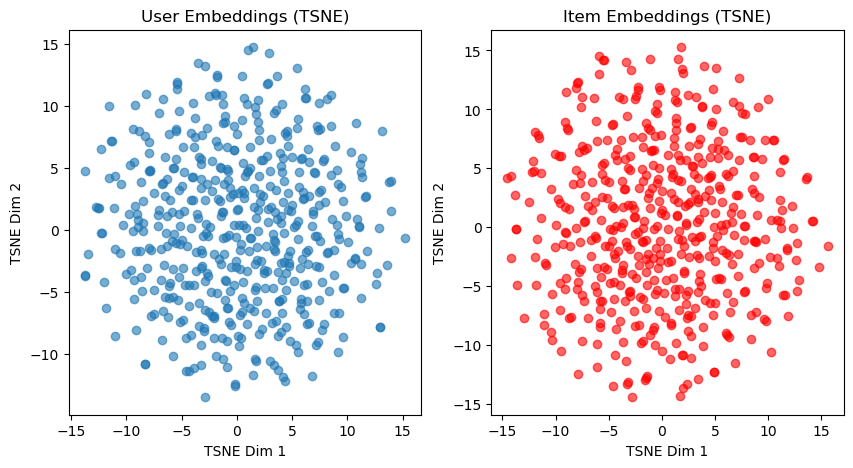

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
def visualize_embeddings(model, num_samples=500):
    user_embeddings = model.user_emb.weight.data.cpu().numpy()[:num_samples]
    item_embeddings = model.item_emb.weight.data.cpu().numpy()[:num_samples]

    tsne = TSNE(n_components=2, random_state=42)
    user_2d = tsne.fit_transform(user_embeddings)
    item_2d = tsne.fit_transform(item_embeddings)

    plt.figure(figsize=(10, 5))

    # User Embeddings
    plt.subplot(1, 2, 1)
    plt.scatter(user_2d[:, 0], user_2d[:, 1], alpha=0.6)
    plt.title("User Embeddings (TSNE)")
    plt.xlabel("TSNE Dim 1")
    plt.ylabel("TSNE Dim 2")

    # Item Embeddings
    plt.subplot(1, 2, 2)
    plt.scatter(item_2d[:, 0], item_2d[:, 1], alpha=0.6, color='r')
    plt.title("Item Embeddings (TSNE)")
    plt.xlabel("TSNE Dim 1")
    plt.ylabel("TSNE Dim 2")

    plt.show()

visualize_embeddings(model)

In [19]:
# ------------------------------------
# 3. Content-based TF-IDF similarity
item_texts = df.groupby('asin')['text'].apply(lambda x: ' '.join(x)).reset_index()
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(item_texts['text'])


In [40]:
import torch
import faiss
import numpy as np
from scipy.sparse import csr_matrix

# ✅ Keep TF-IDF in sparse format (DO NOT convert to dense)
tfidf_matrix = csr_matrix(tfidf_matrix, dtype=np.float32)

# 🔹 Use FAISS HNSW for Approximate Similarity Search
res = faiss.StandardGpuResources()
index = faiss.IndexHNSWFlat(tfidf_matrix.shape[1], 32)  # 32 neighbors
index.hnsw.efConstruction = 200  # Improves recall
index.hnsw.efSearch = 50  # Controls search accuracy

# ⚡ Train FAISS on a smaller subset (~10K samples) to reduce memory
index.train(tfidf_matrix[:1000].toarray())
index.add(tfidf_matrix[:5000].toarray())  # Only add first 50K to save memory

def get_faiss_similarity(item_idx, top_k=10):
    """Get top-K most similar items using FAISS."""
    _, indices = index.search(tfidf_matrix[item_idx].toarray().reshape(1, -1), top_k)
    return indices.flatten()

# ✅ Optimized Hybrid Recommendation
def hybrid_recommend(user_id, alpha=0.7, top_k=5):
    with torch.no_grad():
        items = torch.arange(num_items, device=device)
        user_tensor = torch.full((num_items,), user_id, dtype=torch.long, device=device)
        ncf_scores = model(user_tensor, items).detach().cpu().numpy()

    interacted_items = df[df['user_id'] == user_id]['asin'].tolist()

    if not interacted_items:
        return ncf_scores.argsort()[::-1][:top_k]

    # Get only top-K similar items
    all_similar_items = np.concatenate([get_faiss_similarity(i, top_k=10) for i in interacted_items])
    tfidf_scores = np.bincount(all_similar_items, minlength=num_items)

    tfidf_scores = tfidf_scores / len(interacted_items)
    final_scores = alpha * ncf_scores + (1 - alpha) * tfidf_scores
    rec_items = final_scores.argsort()[::-1][:top_k]
    return rec_items

# 🔥 Generate recommendations for first 10 users
rec_demo = {user: hybrid_recommend(user).tolist() for user in df['user_id'].unique()[:10]}


In [43]:
import json

# Ensure dictionary keys are serializable
rec_demo_serializable = {str(k): v for k, v in rec_demo.items()}  # Convert keys to string if needed

# Save to a JSON file
with open("recommendations_demo.json", "w", encoding="utf-8") as f:
    json.dump(rec_demo_serializable, f, indent=4)  # Pretty-print for readability

print("✅ Recommendations saved successfully!")


✅ Recommendations saved successfully!
